Genera graficas de intensidad a partir de los valores de r0 suministrados

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.special import jv
import os.path
import pickle

plt.rcParams['figure.figsize'] = (5, 4)  # 8*4
plt.rcParams['figure.dpi'] = 100
output_format=".png"

In [22]:
def make_dir(file_or_dir):
    """Given a dir or file path, creates the dir if needed and returns de original string"""
    results_dir=os.path.dirname(file_or_dir)
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    return file_or_dir

Cargamos los valores de $r_0$ generados con los ajustes de _ajuste-seeing-visibilidad-2.ipynb_

In [23]:
with open('intermedio/valoresr0.pkl', 'rb') as f:
    r0dict = pickle.load(f)

Cargamos dataframe con los datos de las estrellas para las simulaciones

In [24]:
files=glob.glob('datos/cortes/*/*.csv')
df=pd.read_hdf('intermedio/tabla.h5', 'df')


In [25]:
def visibility(alphap, B, lamb):
    den = np.pi*alphap*B/lamb
    return 2*np.abs(jv(1, den)/den)

# (Pi (d/2)^2)^2/(\[Lambda] f)^2*(BesselJ[1, Pi a d/(f \[Lambda])] /(Pi a d/( f \[Lambda])))^2 /.unidades;


def PSF(alpha, f, lamb, D):
    den = np.pi*alpha*D/lamb
    return ((pi*(D/2)**2)**2/(lamb*f)**2) * (jv(1, den)/den)**2


In [26]:
gamma = 1
f = 2.8


def sacarI(serie):
    alphap = serie['alphap']  # PAsamos de mas a rad

    lamb = serie['$\lambda$']*10**-9
    dlamb = serie['$d\lambda$']*10**-9
    B = serie['L (mm)']*0.001
    D = serie['D (mm)']*0.001

    I = 2*(1+gamma*np.cos(2*np.pi/lamb*B*alpha))

    V = visibility(alphap, B, lamb)
    I2 = 2*(1+V*np.cos(2*np.pi/lamb*B*alpha))

    psf = PSF(alpha, f, lamb, D)
    I3 = psf*I2

    espectral = (1-np.abs(B*alpha*dlamb/lamb**2))
    I4 = psf*2*(1+V*espectral*np.cos(2*np.pi/lamb*B*alpha))

    return I, I2, I3, I4, V, espectral, psf


In [27]:
from parametros import xlimdict, xlimdef

In [28]:
pi = np.pi
px = 5e-6  # 4.65e-6
N = 10000
a0 = 0.00003
gamma = 1
f = 2.8


paths = []
names = []

for name in glob.glob('datos/cortes/*/*.csv'):
    paths.append(name)
    names.append(name.split('\\')[-1])

ids = [int(n.split('-')[0]) for n in names]

In [29]:
def calculate_I(x_rad,B,D,lamb,r0):
    paper_V=np.exp(-3.44*(B/r0)**(5/3))
    den = np.pi*x_rad*D/lamb
    paper_I=(jv(1,den)/den)**2*(1+paper_V*np.cos(2*pi/lamb*B*x_rad))
    return paper_I/paper_I.max()

10
10


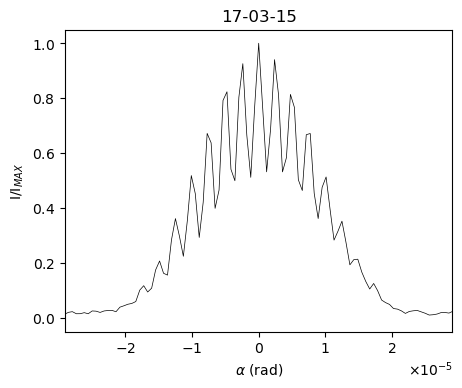

11
11


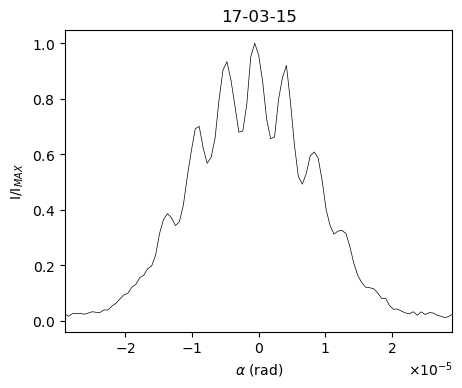

8
8


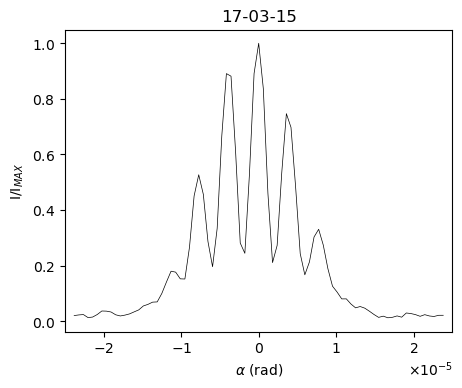

9


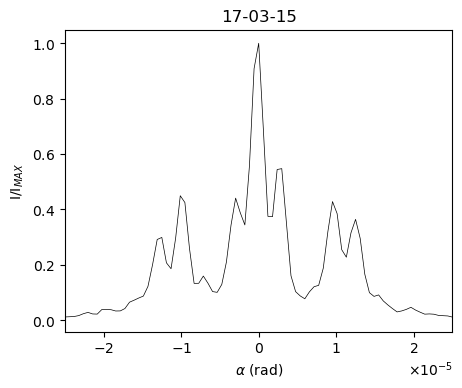

24


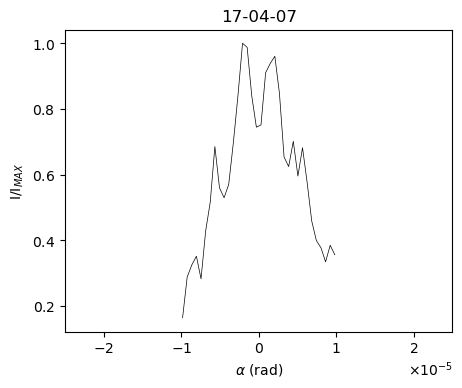

13


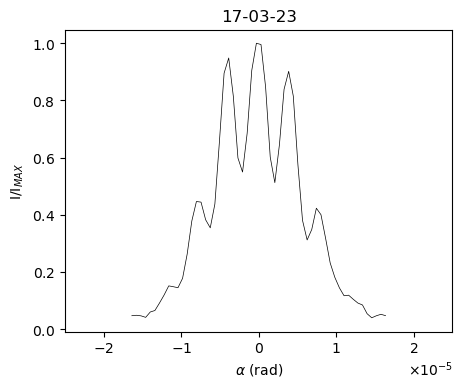

4


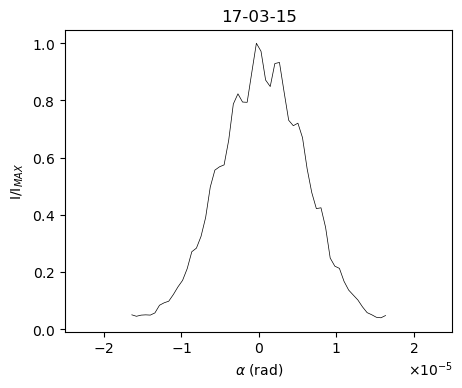

6
6


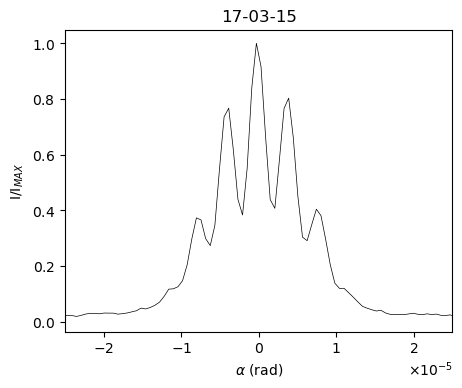

7
7


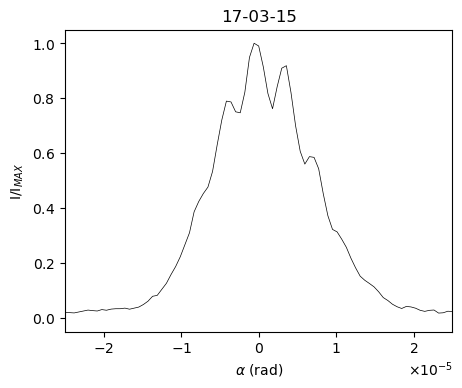

1
1


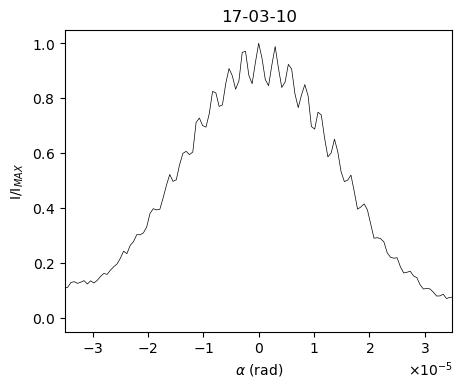

12


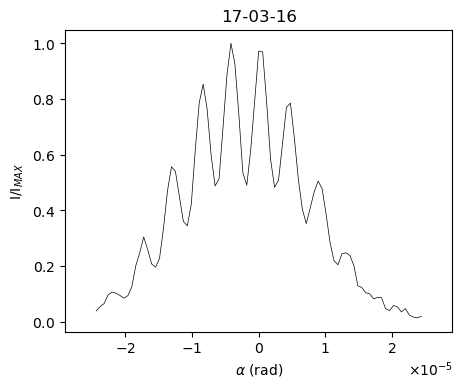

14
14


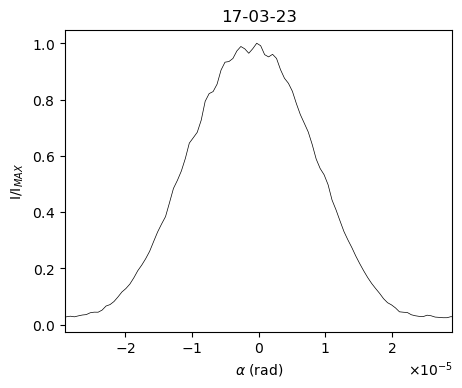

15
15


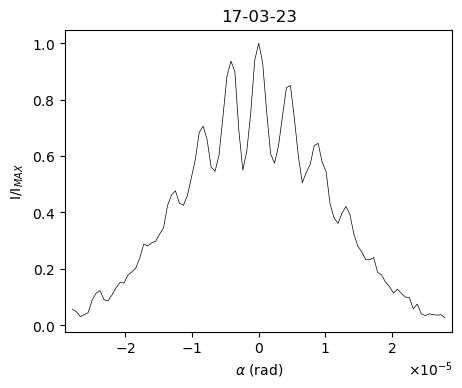

16
16


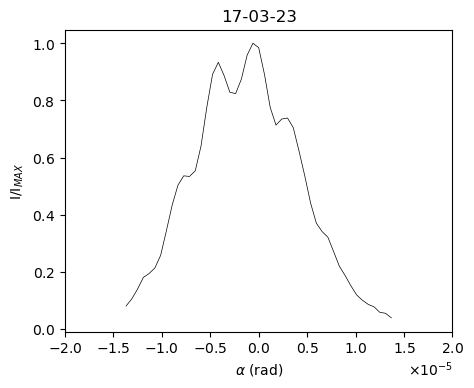

17
17


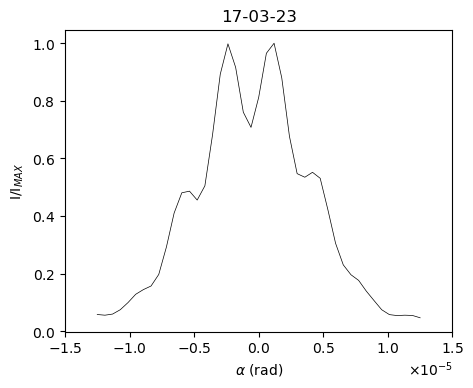

18


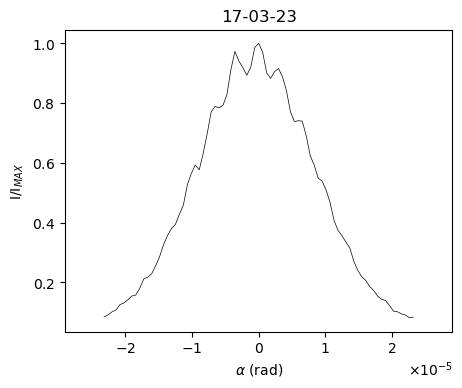

19
19


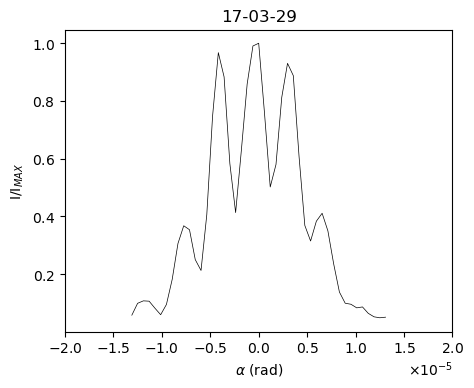

2
2


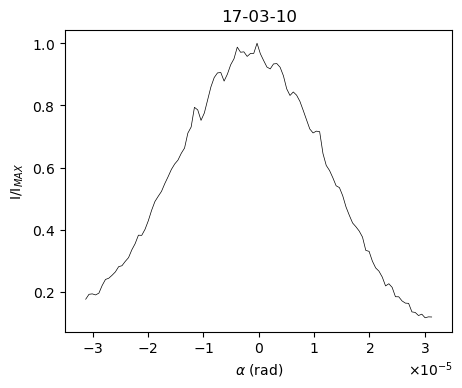

20
20


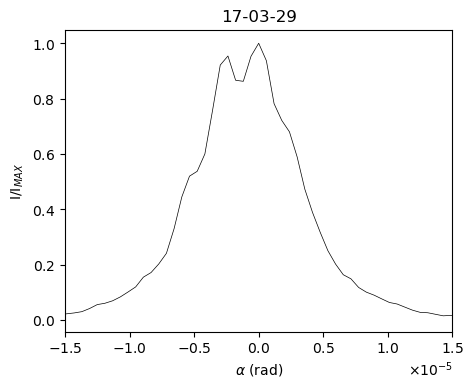

21
21


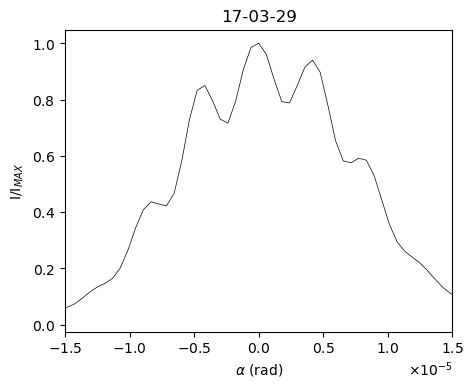

22
22


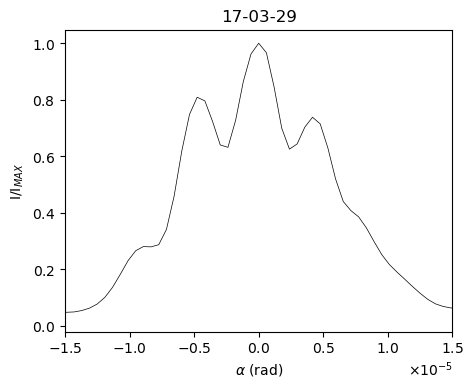

23
23


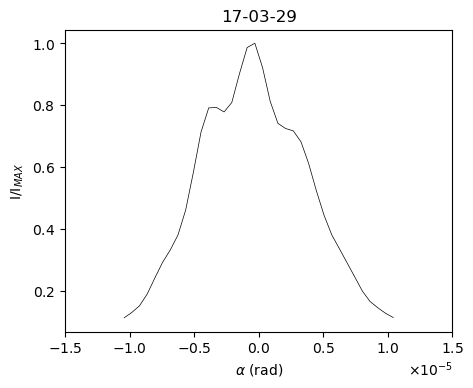

3
3


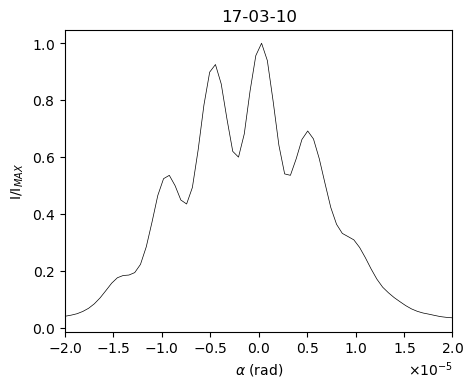

In [30]:
results=[]
for i,n in enumerate(ids):
    plot_theory=False
    if n in r0dict:
        r0=r0dict[n]
        plot_theory=True
    else:
        pass #continue

    serie = df.loc[n]

    lamb = serie['$\lambda$']*10**-9
    B = serie['L (mm)']*0.001
    D = serie['D (mm)']*0.001


    out = str('productos/graficas intensidad teor/'+serie['Objeto']+'/'+str(n)+'-intensidad' +output_format)
    outcortes = str('productos/cortes/'+serie['Objeto']+'/'+str(n)+'-intensidad' +output_format)
    make_dir(out)
    make_dir(outcortes)


    try:
        idn = serie['Imagen']
        csvpath = [file for file in files if file.find(
            '\\'+str(idn)+'-') > 0][0]
        cut = pd.read_csv(csvpath)
        nm = np.max(cut['Distance_(pixels)'])


    except IndexError:
        print(f"Error en {i=},{n=}")
        nm = 1


    nm = nm/2

    m = np.linspace(-nm, nm, N)
    alpha = m*px/f
    alpha_as = alpha/(pi/180/3600)  # *3 cambiado en v3, mejor en cortes

    # Solo se plotea el teorico si se ha calculado el r0 correspondiente
    if plot_theory:
        fig, ax = plt.subplots()
        plt.ticklabel_format(useMathText=True)
        x_rad=alpha_as*(pi/180/3600)
        limite_x=xlimdict.get(n,xlimdef) 
        plt.xlim([-limite_x, limite_x])
        ax.set_xlabel('$\\alpha$ (rad)')
        ax.set_ylabel('I/I$_{MAX}$')  

        date=serie['DATE']
        #ax.set_title(f'{date}')
        
        # cut=pd.read_csv(paths[i])
        # xpixdesplazada=cut['Distance_(pixels)']-cut['Distance_(pixels)'].max()/2.
        # ejex_as=xpixdesplazada*px/f  /(pi/180/3600)/3
        # x_exp_rad=ejex_as*(pi/180/3600)
        # y_exp=cut['Gray_Value']/cut['Gray_Value'].max()

        print(n)
        paper_I=calculate_I(x_rad,B,D,lamb,r0)
        ax.plot(x_rad,paper_I/paper_I.max(),color="black", linewidth=0.5,label=f"r$_0$ = {100*r0:.0f} cm")

        #plt.legend([f"r$_0$ = {100*r0:.0f} cm"])
        
        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
        for item in leg.legendHandles:
            item.set_visible(False)

        plt.savefig(out)
        plt.close()


    fig, ax = plt.subplots()
    plt.ticklabel_format(useMathText=True)
    x_rad=alpha_as*(pi/180/3600)
    limite_x=xlimdict.get(n,xlimdef) 
    plt.xlim([-limite_x, limite_x])
    ax.set_xlabel('$\\alpha$ (rad)')
    ax.set_ylabel('I/I$_{MAX}$')  
    cut=pd.read_csv(paths[i])
    xpixdesplazada=cut['Distance_(pixels)']-cut['Distance_(pixels)'].max()/2.
    ejex_as=xpixdesplazada*px/f  /(pi/180/3600)/3
    x_exp_rad=ejex_as*(pi/180/3600)
    y_exp=cut['Gray_Value']/cut['Gray_Value'].max()

    date=serie['DATE']
    #ax.set_title(f'{date}')

    print(n)
    paper_I=calculate_I(x_rad,B,D,lamb,r0)
    ax.plot(x_exp_rad,y_exp,color="black", linewidth=0.5)
    plt.savefig(outcortes)
    #plt.close()
    plt.show()
    

